In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
%matplotlib inline

## Neural Network excercise (Python implementation)

In this exercise, I am implementing the backpropagation algorithm for neural networks using Python and apply it to the task of hand-written digit recognition.

**Problem description**:
- 5000 total examples of hand-written digit
- Each example is a 20x20 gray-scale image of the digit with each pixel represented by a floating point number indicating the intensity

**Goal**:
- Develop a 3-layer neural network model using backpropagation algorithm
- In addition, dividing the dataset into training data (80%) and test data(20%) to test the accuray of our neural network

### 1. Developing a 3-layer neural network (using entire dataset)

<img src="Neural_Network_schematic.png" />

In [145]:
# loading data
mat = scipy.io.loadmat('ex4data1.mat')
X = mat['X']
Y = mat['y']

#set up parameters for the 3-layer NN model
input_layer = 400  # feature size of input layer
hidden_layer = 25  # feature size of the 2nd layer
num_labels = 10 # feature size of the output layer
lam = 1.0

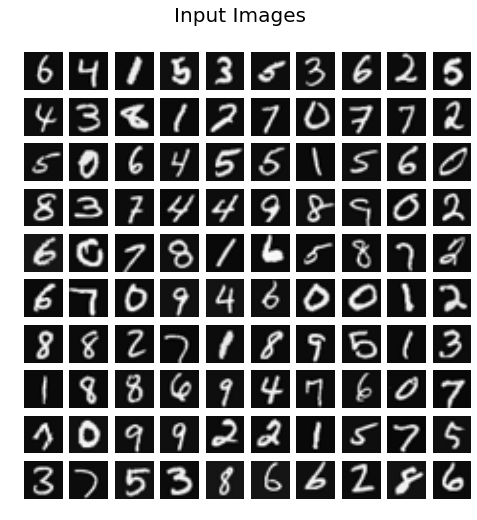

In [147]:
#visualize the data, randomly select 100 samples
samples = np.random.choice(X.shape[0], size=100, replace=False)
fig = plt.figure(figsize = (8, 8))

for i in range(len(samples)):
    data = X[samples[i], :].reshape([20, 20]).T
    data = data/data.max()
    ax = fig.add_subplot(10, 10, i+1)
    ax.imshow(data, 'gray')
    ax.axis('off')
fig.suptitle("Input Images", fontsize=20)

In [148]:
# sigmoid function
def sigmoid(X):
    return 1.0/(1 + np.exp(-X))

# cost function
def nnCostFunc(nn_params, input_layer=input_layer, hidden_layer=hidden_layer, 
               num_labels=num_labels, X=X, Y=Y, lam=1.0):
    theta1 = nn_params[0:(input_layer+1)*hidden_layer].reshape([hidden_layer, input_layer+1])
    theta2 = nn_params[(input_layer+1)*hidden_layer:].reshape([num_labels, hidden_layer+1])
    
    m = X.shape[0]
    
    J = 0 # cost function
    theta1_grad = np.zeros(theta1.shape) # first layer gradient
    theta2_grad = np.zeros(theta2.shape) # second layer gradient

    # adding bias feature to X
    X = np.hstack((np.ones([m, 1]), X))
    
    #forward propagation
    h2 = sigmoid(theta1.dot(X.T))
    h2 = np.vstack((np.ones([1, m]), h2))
    h3 = sigmoid(theta2.dot(h2)) # 10x5000 matrix
    
    #reshape Y data
    Y_2 = np.zeros(h3.shape)
    for col in range(Y.shape[0]):
        Y_2[Y[col, 0] - 1, col] = 1

    J = 1.0/m*np.sum(-Y_2*np.log(h3) - (1 - Y_2)*np.log(1-h3))
    # regularized cost func
    J = J + lam/(2*m)*(np.sum(theta1[:, 1:]**2) + np.sum(theta2[:, 1:]**2))
    
    return J

# gradient for thetas
def calc_gradient(nn_params, input_layer=input_layer, hidden_layer=hidden_layer, 
               num_labels=num_labels, X=X, Y=Y, lam=1.0):

    theta1 = nn_params[0:(input_layer+1)*hidden_layer].reshape([hidden_layer, input_layer+1])
    theta2 = nn_params[(input_layer+1)*hidden_layer:].reshape([num_labels, hidden_layer+1])
    m = X.shape[0]
    
    theta1_grad = np.zeros(theta1.shape) # first layer gradient
    theta2_grad = np.zeros(theta2.shape) # second layer gradient
 
    X = np.hstack((np.ones([m, 1]), X))
    h2 = sigmoid(theta1.dot(X.T))
    h2 = np.vstack((np.ones([1, m]), h2))
    h3 = sigmoid(theta2.dot(h2)) # 10x5000 matrix
    
    Y_2 = np.zeros(h3.shape)
    for col in range(Y.shape[0]):
        Y_2[Y[col, 0] - 1, col] = 1
        
    # Back-propagation
    for i in range(m):
        e_3 = (h3[:, i, None] - Y_2[:, i, None])
        e_2 = theta2.T.dot(e_3)*(h2[:, i, None]*(1 - h2[:, i, None]))
        theta2_grad = theta2_grad + e_3.dot((h2[:, i, None]).T)
        theta1_grad = theta1_grad + e_2[1:].dot(X[i,None, :])
        
    theta2_grad = theta2_grad/m
    theta1_grad = theta1_grad/m
    
    # regularization
    theta2[:, 0] = 0
    theta1[:, 0] = 0
    
    theta2_grad = theta2_grad + (lam/m)*theta2
    theta1_grad = theta1_grad + (lam/m)*theta1

    return np.concatenate((theta1_grad.flatten(), theta2_grad.flatten()) , axis=0)
    
# initialize theta
def ran_init_w(L_in, L_out):
    W = np.zeros([L_out, 1+L_in])
    epsilon = 0.12 # kind of a random choice
    W = np.random.rand(L_out, L_in+1)*2*epsilon - epsilon
    return W

In [149]:
#initialize theta values
i_theta1 = ran_init_w(input_layer, hidden_layer)
i_theta2 = ran_init_w(hidden_layer, num_labels)
initial_nn_params = np.concatenate((i_theta1.flatten(), i_theta2.flatten()) , axis=0)

In [150]:
# training dataset, max 50 iterations
from scipy.optimize import fmin_cg
theta = fmin_cg(f=nnCostFunc, x0=initial_nn_params, fprime=calc_gradient, maxiter=50)

         Current function value: 0.443980
         Iterations: 50
         Function evaluations: 110
         Gradient evaluations: 110


In [151]:
# predict dataset based on training result
def predict(f_theta, X=X, Y=Y, input_layer=input_layer, hidden_layer=hidden_layer, 
               num_labels=num_labels):
    theta1 = f_theta[0:(input_layer+1)*hidden_layer].reshape([hidden_layer, input_layer+1]).copy()
    theta2 = f_theta[(input_layer+1)*hidden_layer:].reshape([num_labels, hidden_layer+1]).copy()
    m = X.shape[0]
    
    X = np.hstack((np.ones([m, 1]), X))
    h2 = sigmoid(theta1.dot(X.T))
    h2 = np.vstack((np.ones([1, m]), h2))
    h3 = sigmoid(theta2.dot(h2))
    
    predict = (h3.argmax(axis=0) + 1).reshape([X.shape[0], 1])
    
    accuracy = np.sum(predict==Y)/float(Y.shape[0])
    print('Model accuracy: {:.2%}'.format(accuracy))
    return predict
  

In [152]:
# Model accuacy
predict_result = predict(theta)

Model accuracy: 96.06%


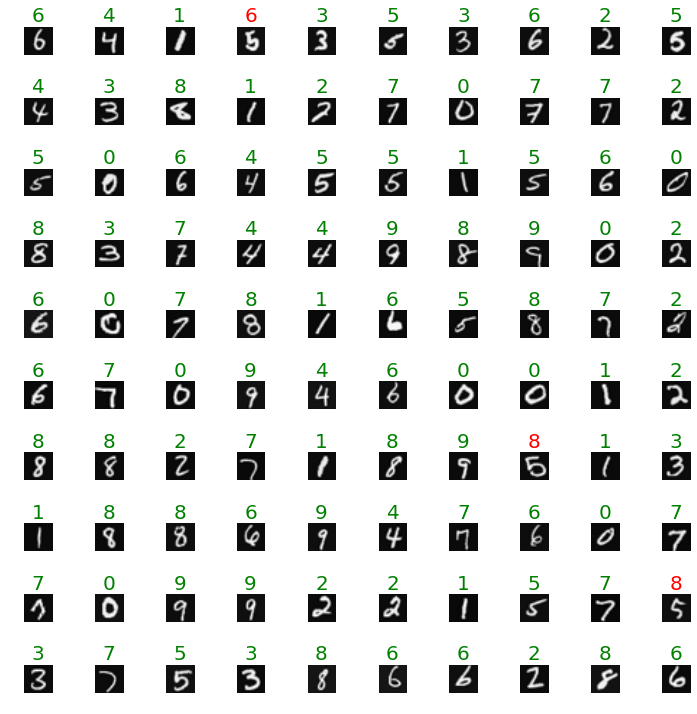

In [153]:
# visualizing model results 
fig = plt.figure(figsize = (10, 10))
for i in range(len(samples)):
    
    data = X[samples[i], :].reshape([20, 20]).T
    data = data/data.max()
    
    ax = fig.add_subplot(10, 10, i+1)
    label = predict_result[samples[i], 0]

    if label == Y[samples[i], 0]:
        color = 'g' # correct prediction
    else:
        color = 'r'# incorrect prediction
    
    if label==10:
        label=0
        
    ax.imshow(data, 'gray')
    ax.axis('off')
    ax.set_title(str(label), color=color, fontsize=20)
fig.tight_layout()

### 2. Training/Testing set

- Randomly select 80% of the data as training set and test on the other 20%

In [155]:
# 80% of the data as training set
total = np.array(range(5000))
training_index = np.random.choice(X.shape[0], size=4000, replace=False)
test_index = np.array([i for i in total if not (i in training_index)])

training_X = X[training_index, :]
training_Y = Y[training_index]

test_X = X[test_index, :]
test_Y = Y[test_index]

In [156]:
# modify the original training functions
def t_costfunc(i_params, X=training_X, Y=training_Y):
    return nnCostFunc(i_params, X=X, Y=Y, lam=1.0)

def t_gradient(n_params, X=training_X, Y=training_Y):
    return calc_gradient(n_params, X=X, Y=Y)

In [157]:
# initialize parameters
t_theta1 = ran_init_w(input_layer, hidden_layer)
t_theta2 = ran_init_w(hidden_layer, num_labels)
t_params = np.concatenate((i_theta1.flatten(), i_theta2.flatten()) , axis=0)

In [158]:
# training data with 50 max iterations
theta = fmin_cg(f=t_costfunc, x0=t_params, fprime=t_gradient, maxiter=50)

         Current function value: 0.430432
         Iterations: 50
         Function evaluations: 111
         Gradient evaluations: 111


In [160]:
# Apply model to test data and calculate odel accuaracy
test_predict = predict(theta, X=test_X, Y=test_Y)

Model accuracy: 92.80%


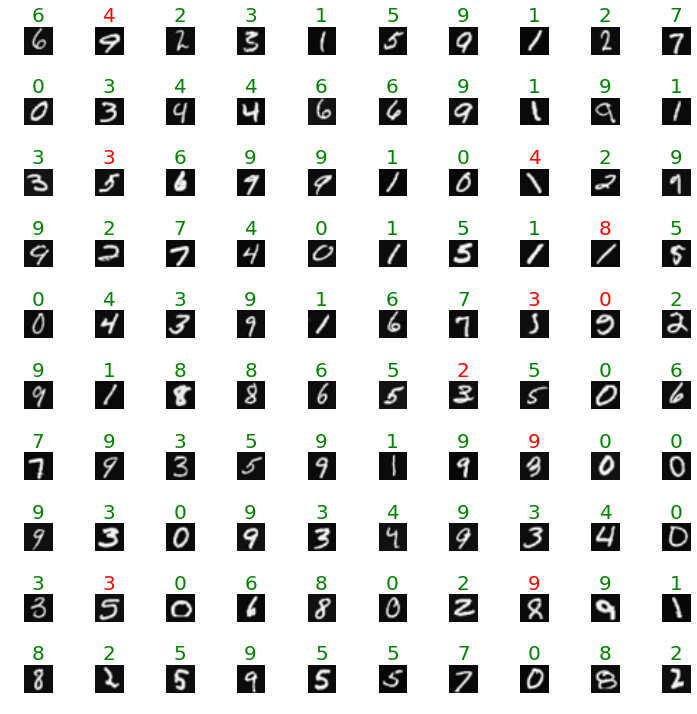

In [162]:
# visualizing test result
samples_2 = np.random.choice(test_Y.shape[0], size=100, replace=False)

fig = plt.figure(figsize = (10, 10))
for i in range(len(samples)):
    
    data = test_X[samples_2[i], :].reshape([20, 20]).T
    data = data/data.max()
    
    ax = fig.add_subplot(10, 10, i+1)
    label = test_predict[samples_2[i], 0]
    if label == test_Y[samples_2[i], 0]:
        color = 'g' # correct prediction
    else:
        color = 'r'# incorrect prediction
    if label==10:
        label=0
        
    ax.imshow(data, 'gray')
    ax.axis('off')
    ax.set_title(str(label), color=color, fontsize=20)
fig.tight_layout()

### 2.1 What about increase max iteration to 500?

In [165]:
theta = fmin_cg(f=t_costfunc, x0=t_params, fprime=t_gradient, maxiter=500)

         Current function value: 0.332185
         Iterations: 500
         Function evaluations: 1192
         Gradient evaluations: 1192


In [166]:
# apply to test data set
test_predict = predict(theta, X=test_X, Y=test_Y)

Model accuracy: 93.40%


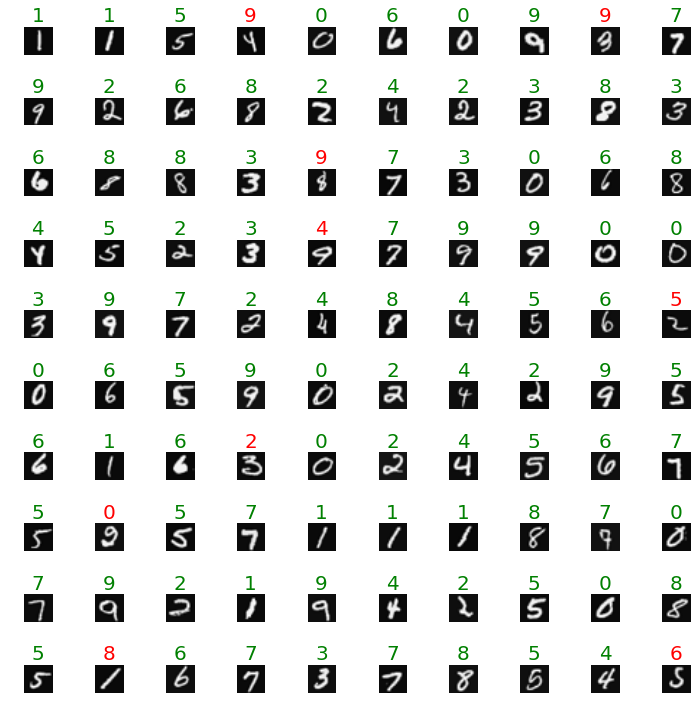

In [167]:
samples_2 = np.random.choice(test_Y.shape[0], size=100, replace=False)

fig = plt.figure(figsize = (10, 10))
for i in range(len(samples)):
    
    data = test_X[samples_2[i], :].reshape([20, 20]).T
    data = data/data.max()
    
    ax = fig.add_subplot(10, 10, i+1)
    label = test_predict[samples_2[i], 0]
    if label == test_Y[samples_2[i], 0]:
        color = 'g' # correct prediction
    else:
        color = 'r'# incorrect prediction
    if label==10:
        label=0
        
    ax.imshow(data, 'gray')
    ax.axis('off')
    ax.set_title(str(label), color=color, fontsize=20)
fig.tight_layout()